# Analysis of Surface Fields

`mom6_tools.MOM6grid` returns an object with MOM6 grid data.

`mom6_tools.latlon_analysis` has a collection of tools used to perform spatial analysis  (e.g., time averages and spatial mean).

The goal of this notebook is the following:

1) server as an example of how to post-process CESM/MOM6 output;

2) create time averages of surface fields;

3) create time-series of globally-averaged surface fields;

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, yaml, argparse
import pandas as pd
import dask, intake
from datetime import datetime, date
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.m6toolbox import cime_xmlquery
from mom6_tools.m6toolbox import add_global_attrs
from mom6_tools.m6plot import xycompare, xyplot
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.surface import get_SSH, get_MLD, get_BLD

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/gmarques/conda-envs/mom6-tools/share/proj failed


Basemap module not found. Some regional plots may not function properly


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [4]:
caseroot = diag_config_yml['Case']['CASEROOT']
casename = cime_xmlquery(caseroot, 'CASE')
DOUT_S = cime_xmlquery(caseroot, 'DOUT_S')
if DOUT_S:
  OUTDIR = cime_xmlquery(caseroot, 'DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = cime_xmlquery(caseroot, 'RUNDIR')

In [5]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

# load avg dates
avg = diag_config_yml['Avg']

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = casename
args.native = casename+diag_config_yml['Fnames']['native']
args.static = casename+diag_config_yml['Fnames']['static']
args.geom =   casename+diag_config_yml['Fnames']['geom']
args.mld_obs = "mld-deboyer-tx2_3v2"
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [6]:
if not os.path.isdir('PNG/BLD'):
  print('Creating a directory to place figures (PNG/BLD)... \n')
  os.system('mkdir -p PNG/BLD')
if not os.path.isdir('PNG/MLD'):
  print('Creating a directory to place figures (PNG/MLD)... \n')
  os.system('mkdir -p PNG/MLD')
if not os.path.isdir('ncfiles'):
  print('Creating a directory to place netcdf files (ncfiles)... \n')
  os.system('mkdir ncfiles')    

In [7]:
parallel = False
if args.nw > 1:
  parallel = True
  cluster = NCARCluster()
  cluster.scale(args.nw)
  client = Client(cluster)
  client

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/42779/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/42779/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.100:32845,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/High-mem/proxy/42779/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
# read grid info
geom_file = OUTDIR+'/'+args.geom
if os.path.exists(geom_file):
  grd = MOM6grid(OUTDIR+'/'+args.static, geom_file)
else:
  grd = MOM6grid(OUTDIR+'/'+args.static)

try:
  depth = grd.depth_ocean
except:
  depth = grd.deptho

MOM6 grid successfully loaded... 



In [10]:
print('Reading native dataset...')
startTime = datetime.now()

def preprocess(ds):
    ''' Compute montly averages and return the dataset with variables'''
    variables = ['oml','mlotst','tos','SSH', 'SSU', 'SSV', 'speed']
    if 'time_bounds' in ds.variables:
      variables.append('time_bounds')
    elif 'time_bnds' in ds.variables:
      variables.append('time_bnds')
    for v in variables:
      if v not in ds.variables:
        ds[v] = xr.zeros_like(ds.SSH)
    return ds[variables]

ds1 = xr.open_mfdataset(OUTDIR+args.native, parallel=parallel)
ds = preprocess(ds1)

print('Time elasped: ', datetime.now() - startTime)

Reading native dataset...
Time elasped:  0:02:16.685705


In [11]:
print('Selecting data between {} and {}...'.format(args.start_date, args.end_date))
ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

Selecting data between 0031-01-01 and 0062-01-01...


In [12]:
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
mld_obs = catalog[args.mld_obs].to_dask()
# uncomment to list all datasets available
#list(catalog)

### Mixed layer depth

In [13]:
%matplotlib inline
# MLD
get_MLD(ds_sel,'mlotst', mld_obs, grd, args)

Computing monthly MLD climatology...
Time elasped:  0:00:09.007238

 Plotting...


### Boundary layer depth

Computing monthly BLD climatology...
Time elasped:  0:00:09.901577

 Plotting...


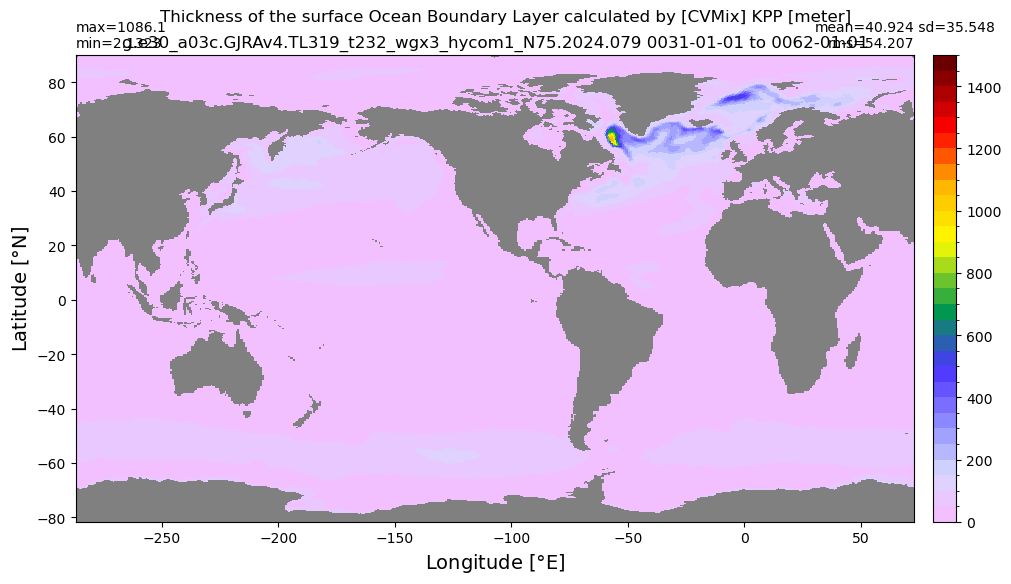

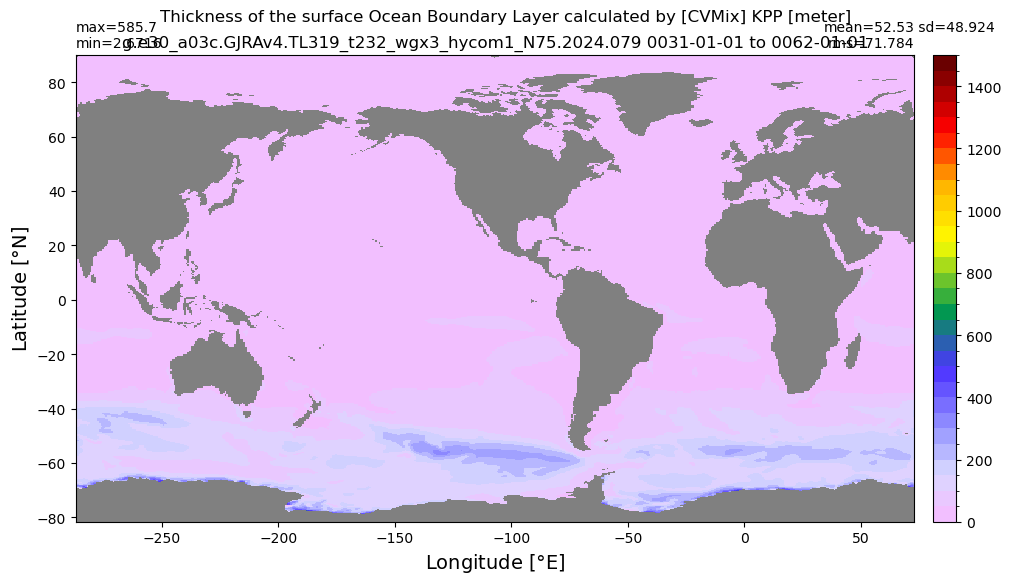

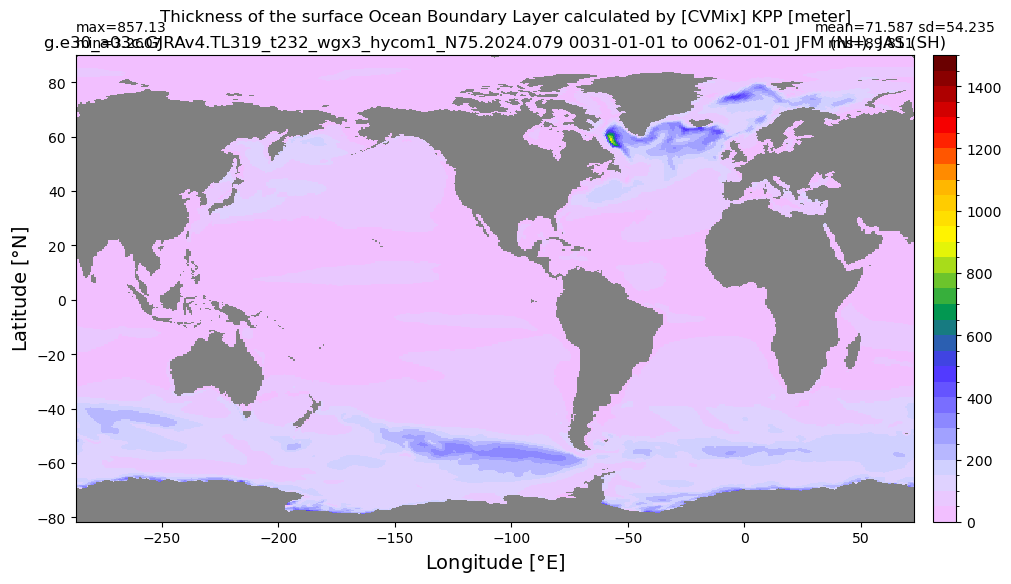

In [14]:
get_BLD(ds_sel, 'oml', grd, args)

In [15]:
# SSH (not working)
#get_SSH(ds, 'SSH', grd, args)

In [16]:
if parallel:
    print('\n Releasing workers...')
    client.close(); cluster.close()


 Releasing workers...
